In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
import scipy.stats as stats
from sklearn.metrics import r2_score
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [46]:

#1. Which factors make a patient more likely to have a stroke?
#2. Can these risk factors be used to predict whether a new patient is likely to have a stroke?

In [47]:
# Visualizing and pre-processing the data

df = pd.read_csv('/Users/brettscheib/Downloads/DSC 140/stroke-final-project.csv')

# because there were NaN in the bmi column, these values were replaced with the mean of the column
mean_bmi = df['bmi'].mean()
df['bmi'] = df['bmi'].fillna(mean_bmi)

# the website cited that "Unknown" values meant that the information was unavailable for this patient
# so the "Unknown" values were left in the smoking_status column as a separate category

df = df.replace({'hypertension': {0: 'No', 1: 'Yes'}, 'heart_disease': {0: 'No', 1: 'Yes'}, 'stroke': {0: 'No', 1: 'Yes'}})
# make these nominal columns categorical instead of numerical

display(df)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,No,Yes,Yes,Private,Urban,228.69,36.600000,formerly smoked,Yes
1,51676,Female,61.0,No,No,Yes,Self-employed,Rural,202.21,28.893237,never smoked,Yes
2,31112,Male,80.0,No,Yes,Yes,Private,Rural,105.92,32.500000,never smoked,Yes
3,60182,Female,49.0,No,No,Yes,Private,Urban,171.23,34.400000,smokes,Yes
4,1665,Female,79.0,Yes,No,Yes,Self-employed,Rural,174.12,24.000000,never smoked,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,Yes,No,Yes,Private,Urban,83.75,28.893237,never smoked,No
5106,44873,Female,81.0,No,No,Yes,Self-employed,Urban,125.20,40.000000,never smoked,No
5107,19723,Female,35.0,No,No,Yes,Self-employed,Rural,82.99,30.600000,never smoked,No
5108,37544,Male,51.0,No,No,Yes,Private,Rural,166.29,25.600000,formerly smoked,No


In [48]:
df.describe()

,id,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,43.226614,106.147677,28.893237
std,21161.721625,22.612647,45.283560,7.698018
min,67.000000,0.080000,55.120000,10.300000
25%,17741.250000,25.000000,77.245000,23.800000
50%,36932.000000,45.000000,91.885000,28.400000
75%,54682.000000,61.000000,114.090000,32.800000
max,72940.000000,82.000000,271.740000,97.600000


In [49]:
for i in df.columns:
    if (type(df[i][0]) != str):
        print(i + " (numeric)")
        print("mean = {0}".format(df[i].mean()))
        print("min = {0}".format(df[i].min()))
        print("max = {0}".format(df[i].max()))
        print("range = {0}".format(df[i].max() - df[i].min()))
        print("standard deviation = {0}".format(df[i].std()))
        
    else:
        print(i + " (categorical)")
        print("possible values:")
        print(df[i].unique())
    print("\n")
    

id (numeric)
mean = 36517.82935420744
min = 67
max = 72940
range = 72873
standard deviation = 21161.721624827136


gender (categorical)
possible values:
['Male' 'Female' 'Other']


age (numeric)
mean = 43.226614481409015
min = 0.08
max = 82.0
range = 81.92
standard deviation = 22.61264672311352


hypertension (categorical)
possible values:
['No' 'Yes']


heart_disease (categorical)
possible values:
['Yes' 'No']


ever_married (categorical)
possible values:
['Yes' 'No']


work_type (categorical)
possible values:
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']


Residence_type (categorical)
possible values:
['Urban' 'Rural']


avg_glucose_level (numeric)
mean = 106.14767710371804
min = 55.12
max = 271.74
range = 216.62
standard deviation = 45.28356015058203


bmi (numeric)
mean = 28.89323691179472
min = 10.3
max = 97.6
range = 87.3
standard deviation = 7.698017826857077


smoking_status (categorical)
possible values:
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


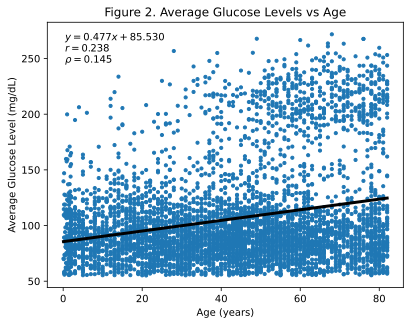

In [50]:
# Age vs Glucose levels

plt.figure()
ax = plt.subplot()
plt.scatter(df["age"],df["avg_glucose_level"], s=10)

r = stats.linregress(df['age'],df['avg_glucose_level'])
m = r.slope
b = r.intercept
x_fit = np.linspace(min(df['age']),max(df['age']),100)
y_fit = m*x_fit+b
pearson_r, pval = stats.pearsonr(df['age'],df['avg_glucose_level'])
spearman_r, pval2 = stats.spearmanr(df['age'], df['avg_glucose_level'])

plt.plot(x_fit,y_fit,c='k', linewidth=3)
plt.text(0.05, 0.9,'$y={0:.3f}x+{1:.3f}$\n$r={2:.3f}$\n'.format(m,b,pearson_r) + r'$\rho={0:.3f}$'.format(spearman_r),horizontalalignment='left',verticalalignment='center',transform=ax.transAxes)

plt.title("Figure 2. Average Glucose Levels vs Age")
plt.xlabel("Age (years)")
plt.ylabel("Average Glucose Level (mg/dL)")

plt.show()


# There is a slight positive linear association between average glucose levels and age (r=0.238, rho=0.145)


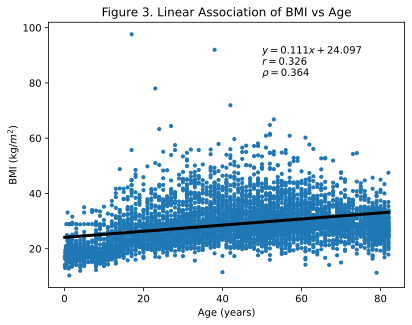

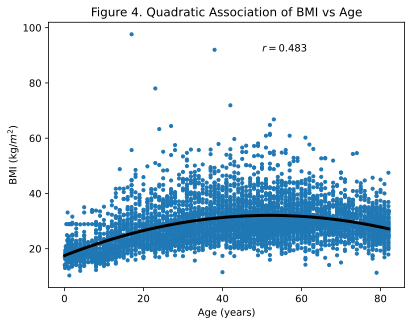

In [51]:
# Age vs BMI

plt.figure()
ax = plt.subplot()
plt.scatter(df["age"],df["bmi"], s=10)

r = stats.linregress(df['age'],df['bmi'])
m = r.slope
b = r.intercept
x_fit = np.linspace(min(df['age']),max(df['age']),100)
y_fit = m*x_fit+b
pearson_r, pval = stats.pearsonr(df['age'],df['bmi'])
spearman_r, pval2 = stats.spearmanr(df['age'], df['bmi'])

plt.plot(x_fit,y_fit,c='k', linewidth=3)
plt.text(0.6, 0.85,'$y={0:.3f}x+{1:.3f}$\n$r={2:.3f}$\n'.format(m,b,pearson_r) + r'$\rho={0:.3f}$'.format(spearman_r),horizontalalignment='left',verticalalignment='center',transform=ax.transAxes)

plt.title("Figure 3. Linear Association of BMI vs Age")
plt.xlabel("Age (years)")
plt.ylabel("BMI (kg/$m^2$)")

plt.show()

# There is a slight positive linear association between BMI and age (r=0.326, rho=0.364)
# But it seems that a quadratic model may fit better

plt.figure()
ax = plt.subplot()
plt.scatter(df["age"],df["bmi"], s=10)
quadratic = np.poly1d(np.polyfit(df['age'], df['bmi'], 2))
plt.plot(x_fit, quadratic(x_fit), c='k', linewidth=3)
plt.text(0.6, 0.9,'$r={0:.3f}$'.format(r2_score(df['bmi'], quadratic(df['age']))**0.5),horizontalalignment='left',verticalalignment='center',transform=ax.transAxes)
plt.title("Figure 4. Quadratic Association of BMI vs Age")
plt.xlabel("Age (years)")
plt.ylabel("BMI (kg/$m^2$)")

plt.show()

# The quadratic regression has a stronger correlation (0.483) than the linear regression, implying that a 
# quadratic model is more appropriate

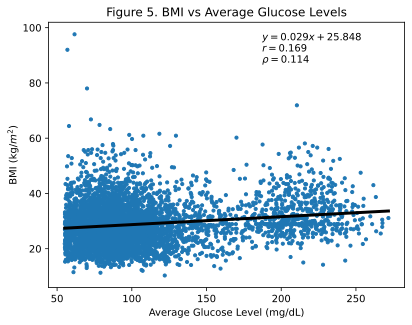

In [52]:
# BMI vs Glucose Levels

plt.figure()
ax = plt.subplot()
plt.scatter(df["avg_glucose_level"],df["bmi"], s=10)

r = stats.linregress(df['avg_glucose_level'],df['bmi'])
m = r.slope
b = r.intercept
x_fit = np.linspace(min(df['avg_glucose_level']),max(df['avg_glucose_level']),100)
y_fit = m*x_fit+b
pearson_r, pval = stats.pearsonr(df['avg_glucose_level'],df['bmi'])
spearman_r, pval2 = stats.spearmanr(df['avg_glucose_level'], df['bmi'])

plt.plot(x_fit,y_fit,c='k', linewidth=3)
plt.text(0.6, 0.9,'$y={0:.3f}x+{1:.3f}$\n$r={2:.3f}$\n'.format(m,b,pearson_r) + r'$\rho={0:.3f}$'.format(spearman_r),horizontalalignment='left',verticalalignment='center',transform=ax.transAxes)

plt.title("Figure 5. BMI vs Average Glucose Levels")
plt.xlabel("Average Glucose Level (mg/dL)")
plt.ylabel("BMI (kg/$m^2$)")

plt.show()


# The low correlation values of r = 0.156, rho=0.109 indicates that there is no significant association between 
# average glucose levels and BMI


In [53]:
# Numerical Correlations with Stroke

# first defining a function to create a plot commonly used below

def percent_stacked_binned_histogram(x):
    # divide the numerical data into bins
    df['bins'] = pd.cut(df[x], np.linspace(df[x].min(), df[x].max(), 15))
    # use groupby to count the number of people in each bin who answered No/Yes for stroke
    df_grouped = df.groupby([df['bins'], 'stroke'])[x].count()
    # another groupby to count the total number of responses in each bin group
    total = df.groupby([df['bins']])[x].count()
    # divide for a percentage of the total
    df_percents = df_grouped*100/total
    # convert back to a dataframe
    df_percents = df_percents.unstack()
    return df_percents

def percent_stacked_binned_bar(x):
    # for categorical data, no binning required
    df_grouped = df.groupby([df[x], 'stroke'])[x].count()
    # another groupby to count the total number of responses in each bin group
    total = df.groupby([df[x]])[x].count()
    # divide for a percentage of the total
    df_percents = df_grouped*100/total
    # convert back to a dataframe
    df_percents = df_percents.unstack()
    return df_percents

pvalue for age is 7.031e-71
average age of patients who had a stroke is 67.7
average age of patients without a stroke is 42.0


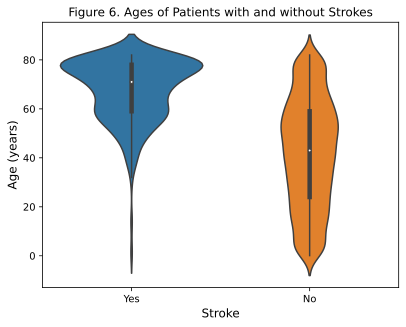

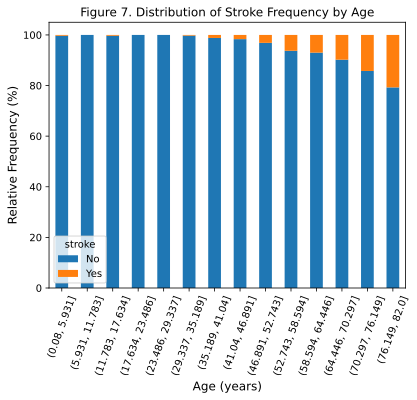

In [54]:
# Numerical Correlations with Stroke

# is the average age of patients who had a stroke different than that of patients who have not had a stroke?
age_stroke = df.query("stroke=='Yes'")['age']
age_noStroke = df.query("stroke=='No'")['age']

statistic, pvalue = stats.ttest_ind(age_stroke, age_noStroke)
print("pvalue for age is {0:.3e}".format(pvalue)) # yes, the mean ages are significantly different (p<0.05)

print("average age of patients who had a stroke is {0:.1f}".format(age_stroke.mean()))
print("average age of patients without a stroke is {0:.1f}".format(age_noStroke.mean()))

# violin plot of the data
plt.figure()
sns.violinplot(data=df, x='stroke', y='age')
plt.xlabel("Stroke", fontsize = 12)
plt.ylabel("Age (years)", fontsize = 12)
plt.title("Figure 6. Ages of Patients with and without Strokes")

plt.show()

percent_stacked_binned_histogram('age').plot.bar(stacked=True)
plt.xticks(rotation=70)
plt.title('Figure 7. Distribution of Stroke Frequency by Age')
plt.xlabel('Age (years)', fontsize = 12)
plt.ylabel('Relative Frequency (%)', fontsize=12)

plt.show()


pvalue for BMI is 5.362e-03
average BMI of patients who had a stroke is 30.2
average BMI of patients without a stroke is 28.8


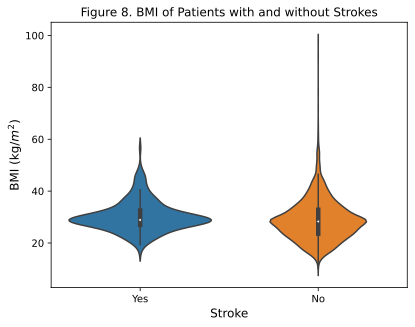

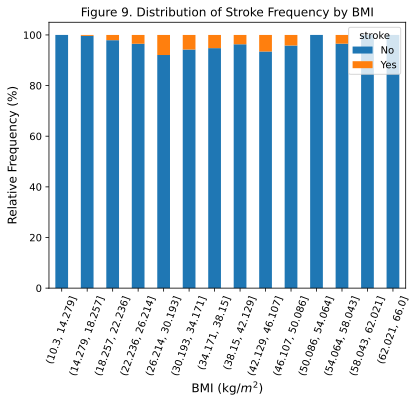

In [55]:

# is the average BMI of patients who had a stroke different than that of patients who have not had a stroke?
bmi_stroke = df.query("stroke=='Yes'")['bmi']
bmi_noStroke = df.query("stroke=='No'")['bmi']

statistic, pvalue = stats.ttest_ind(bmi_stroke, bmi_noStroke)
print("pvalue for BMI is {0:.3e}".format(pvalue)) # yes, the mean BMI's are significantly different (p<0.05)

print("average BMI of patients who had a stroke is {0:.1f}".format(bmi_stroke.mean()))
print("average BMI of patients without a stroke is {0:.1f}".format(bmi_noStroke.mean()))

# violin plot of the data
plt.figure()
sns.violinplot(data=df, x='stroke', y='bmi')
plt.xlabel("Stroke", fontsize = 12)
plt.ylabel("BMI (kg/$m^2$)", fontsize = 12)
plt.title("Figure 8. BMI of Patients with and without Strokes")

plt.show()

# doing this one manually to adjust the linspace to exclude a few extreme upper outliers
df['bmi_bins'] = pd.cut(df['bmi'], np.linspace(df['bmi'].min(), 66, 15))
df_grouped = df.groupby([df['bmi_bins'], 'stroke'])['bmi'].count()
total = df.groupby([df['bmi_bins']])['bmi'].count()
df_percents = df_grouped*100/total
df_percents = df_percents.unstack()

df_percents.plot.bar(stacked=True)
plt.xticks(rotation=70)
plt.title('Figure 9. Distribution of Stroke Frequency by BMI')
plt.xlabel('BMI (kg/$m^2$)', fontsize = 12)
plt.ylabel('Relative Frequency (%)', fontsize=12)

plt.show()

pvalue for average glucose level is 2.768e-21
average glucose level of patients who had a stroke is 132.5
average glucose level of patients without a stroke is 104.8


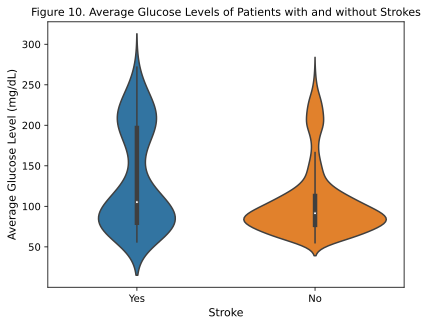

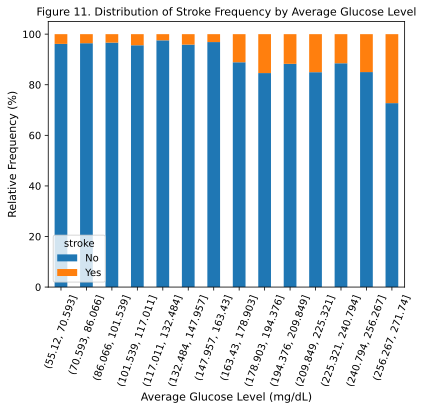

In [56]:

# is the average glucose level of patients who had a stroke different than that of patients who have not had a stroke?
avg_glucose_level_stroke = df.query("stroke=='Yes'")['avg_glucose_level']
avg_glucose_level_noStroke = df.query("stroke=='No'")['avg_glucose_level']

statistic, pvalue = stats.ttest_ind(avg_glucose_level_stroke, avg_glucose_level_noStroke)
print("pvalue for average glucose level is {0:.3e}".format(pvalue)) # yes, the mean glucose levels are significantly different (p<0.05)

print("average glucose level of patients who had a stroke is {0:.1f}".format(avg_glucose_level_stroke.mean()))
print("average glucose level of patients without a stroke is {0:.1f}".format(avg_glucose_level_noStroke.mean()))

# violin plot of the data
plt.figure()
sns.violinplot(data=df, x='stroke', y='avg_glucose_level')
plt.xlabel("Stroke", fontsize = 11)
plt.ylabel("Average Glucose Level (mg/dL)", fontsize = 11)
plt.title("Figure 10. Average Glucose Levels of Patients with and without Strokes", fontsize=11)

plt.show()

percent_stacked_binned_histogram('avg_glucose_level').plot.bar(stacked=True)
plt.xticks(rotation=70)
plt.title('Figure 11. Distribution of Stroke Frequency by Average Glucose Level', fontsize=11)
plt.xlabel('Average Glucose Level (mg/dL)', fontsize = 11)
plt.ylabel('Relative Frequency (%)', fontsize=11)

plt.show()

In [57]:
# Categorical Relationships

categories = ['gender','hypertension','heart_disease','ever_married','work_type','Residence_type','smoking_status']

pvals = []

for i in categories: # do a crosstab and contingency for each categorical variable vs stroke
    A = i
    B = 'stroke'
    
    contingency = pd.crosstab(df[A].dropna(),df[B].dropna())
    c, p, dof, expected = chi2_contingency(contingency)
    print("The p-value for {0} and stroke is {1}".format(i,p))
    
    for index,j in enumerate(contingency.index): 
        print("Fraction having a stroke in group "+j+": " + str(contingency['Yes'][index]/contingency['No'][index]))
        # this prints the fraction of each group that has had a stroke
        # this helps to see which groups are high/low when the difference is deemed significant
        
    pvals.append(p)
    display(contingency)
    print("\n")

df_pvals = pd.DataFrame(data=pvals, columns=['p-values'], index=categories) #create table of pvalues

display(df_pvals)



The p-value for gender and stroke is 0.7895490538408245
Fraction having a stroke in group Female: 0.04942166140904311
Fraction having a stroke in group Male: 0.053811659192825115
Fraction having a stroke in group Other: 0.0


stroke,No,Yes
gender,,
Female,2853,141
Male,2007,108
Other,1,0




The p-value for hypertension and stroke is 1.661621901511823e-19
Fraction having a stroke in group No: 0.04131858207270264
Fraction having a stroke in group Yes: 0.1527777777777778


stroke,No,Yes
hypertension,,
No,4429,183
Yes,432,66




The p-value for heart_disease and stroke is 2.0887845685229236e-21
Fraction having a stroke in group No: 0.043609671848013815
Fraction having a stroke in group Yes: 0.2052401746724891


stroke,No,Yes
heart_disease,,
No,4632,202
Yes,229,47




The p-value for ever_married and stroke is 1.6389021142314745e-14
Fraction having a stroke in group No: 0.01678240740740741
Fraction having a stroke in group Yes: 0.07022023619533993


stroke,No,Yes
ever_married,,
No,1728,29
Yes,3133,220




The p-value for work_type and stroke is 5.397707801896119e-10
Fraction having a stroke in group Govt_job: 0.052884615384615384
Fraction having a stroke in group Never_worked: 0.0
Fraction having a stroke in group Private: 0.05367435158501441
Fraction having a stroke in group Self-employed: 0.08620689655172414
Fraction having a stroke in group children: 0.00291970802919708


stroke,No,Yes
work_type,,
Govt_job,624,33
Never_worked,22,0
Private,2776,149
Self-employed,754,65
children,685,2




The p-value for Residence_type and stroke is 0.29833169286876987
Fraction having a stroke in group Rural: 0.0475
Fraction having a stroke in group Urban: 0.054855749695245835


stroke,No,Yes
Residence_type,,
Rural,2400,114
Urban,2461,135




The p-value for smoking_status and stroke is 2.0853997025008455e-06
Fraction having a stroke in group Unknown: 0.03139612558450234
Fraction having a stroke in group formerly smoked: 0.08588957055214724
Fraction having a stroke in group never smoked: 0.049944506104328525
Fraction having a stroke in group smokes: 0.05622489959839357


stroke,No,Yes
smoking_status,,
Unknown,1497,47
formerly smoked,815,70
never smoked,1802,90
smokes,747,42


,p-values
gender,7.895491e-01
hypertension,1.661622e-19
heart_disease,2.088785e-21
ever_married,1.638902e-14
work_type,5.397708e-10
Residence_type,2.983317e-01
smoking_status,2.085400e-06


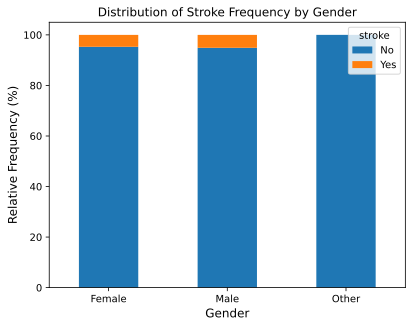

average age of males is 42.483
average age of females is 43.757


In [58]:
percent_stacked_binned_bar('gender').plot.bar(stacked=True)
plt.xticks(rotation=0)
plt.title('Distribution of Stroke Frequency by Gender')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Relative Frequency (%)', fontsize=12)

plt.show()

# pvalue was large, no significant difference between male and female (other excluded bc only 1 entry)

male_age = df.query("gender=='Male'")['age']
female_age = df.query("gender=='Female'")['age']
print("average age of males is {0:.3f}".format(male_age.mean()))
print("average age of females is {0:.3f}".format(female_age.mean()))

# gender is not affected by age

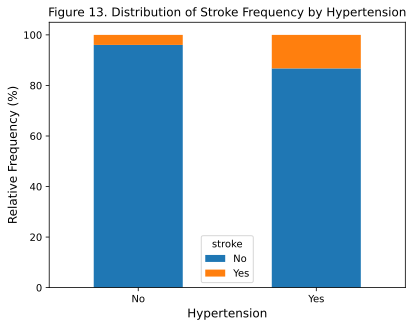

average age of patients with hypertension is 62.245
average age of patients without hypertension is 41.173


In [59]:
percent_stacked_binned_bar('hypertension').plot.bar(stacked=True)
plt.xticks(rotation=0)
plt.title('Figure 13. Distribution of Stroke Frequency by Hypertension')
plt.xlabel('Hypertension', fontsize=12)
plt.ylabel('Relative Frequency (%)', fontsize=12)

plt.show()

yes_age = df.query("hypertension=='Yes'")['age']
no_age = df.query("hypertension=='No'")['age']
print("average age of patients with hypertension is {0:.3f}".format(yes_age.mean()))
print("average age of patients without hypertension is {0:.3f}".format(no_age.mean()))

# hypertension is affected by age

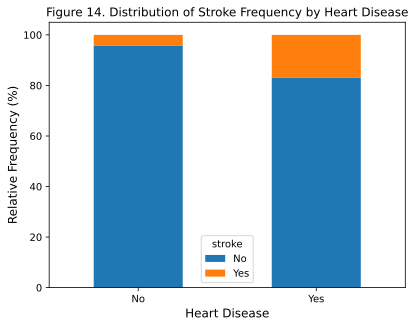

average age of patients with heart disease is 68.188
average age of patients without heart disease is 41.801


In [60]:
percent_stacked_binned_bar('heart_disease').plot.bar(stacked=True)
plt.xticks(rotation=0)
plt.title('Figure 14. Distribution of Stroke Frequency by Heart Disease')
plt.xlabel('Heart Disease', fontsize=12)
plt.ylabel('Relative Frequency (%)', fontsize=12)

plt.show()

yes_age = df.query("heart_disease=='Yes'")['age']
no_age = df.query("heart_disease=='No'")['age']
print("average age of patients with heart disease is {0:.3f}".format(yes_age.mean()))
print("average age of patients without heart disease is {0:.3f}".format(no_age.mean()))

# heart disease is affected by age

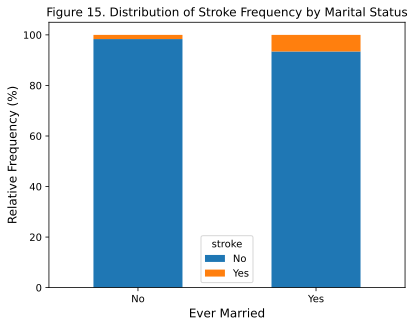

average age of patients who have been married is 54.342
average age of patients who have not been married is 22.014


In [61]:
percent_stacked_binned_bar('ever_married').plot.bar(stacked=True)
plt.xticks(rotation=0)
plt.title('Figure 15. Distribution of Stroke Frequency by Marital Status')
plt.xlabel('Ever Married', fontsize=12)
plt.ylabel('Relative Frequency (%)', fontsize=12)

plt.show()

yes_age = df.query("ever_married=='Yes'")['age']
no_age = df.query("ever_married=='No'")['age']
print("average age of patients who have been married is {0:.3f}".format(yes_age.mean()))
print("average age of patients who have not been married is {0:.3f}".format(no_age.mean()))

# marital status is affected by age

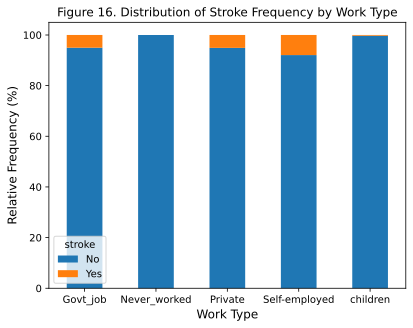

average age of patients with a government job is 50.880
average age of patients who never worked is 16.182
average age of patients with a private job is 45.504
average age of patients who are self-employed is 60.201
average age of patients who are children is 6.841


In [62]:
percent_stacked_binned_bar('work_type').plot.bar(stacked=True)
plt.xticks(rotation=0)
plt.title('Figure 16. Distribution of Stroke Frequency by Work Type')
plt.xlabel('Work Type', fontsize=12)
plt.ylabel('Relative Frequency (%)', fontsize=12)

plt.show()

govt_job_age = df.query("work_type=='Govt_job'")['age']
never_worked_age = df.query("work_type=='Never_worked'")['age']
private_age = df.query("work_type=='Private'")['age']
self_employed_age = df.query("work_type=='Self-employed'")['age']
children_age = df.query("work_type=='children'")['age']
print("average age of patients with a government job is {0:.3f}".format(govt_job_age.mean()))
print("average age of patients who never worked is {0:.3f}".format(never_worked_age.mean()))
print("average age of patients with a private job is {0:.3f}".format(private_age.mean()))
print("average age of patients who are self-employed is {0:.3f}".format(self_employed_age.mean()))
print("average age of patients who are children is {0:.3f}".format(children_age.mean()))

# work type is affected by age

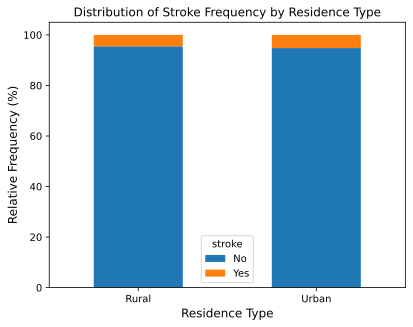

average age of patients who live in urban is 43.542
average age of patients who live in rural is 42.901


In [63]:
percent_stacked_binned_bar('Residence_type').plot.bar(stacked=True)
plt.xticks(rotation=0)
plt.title('Distribution of Stroke Frequency by Residence Type')
plt.xlabel('Residence Type', fontsize=12)
plt.ylabel('Relative Frequency (%)', fontsize=12)

plt.show()

urban_age = df.query("Residence_type=='Urban'")['age']
rural_age = df.query("Residence_type=='Rural'")['age']
print("average age of patients who live in urban is {0:.3f}".format(urban_age.mean()))
print("average age of patients who live in rural is {0:.3f}".format(rural_age.mean()))

# residence type is not affected by age

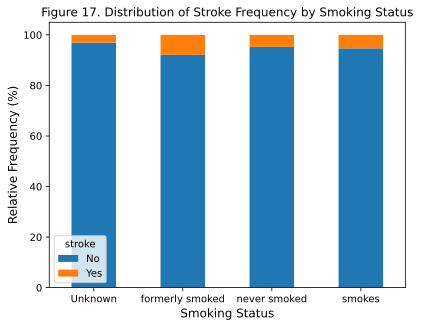

average age of patients with unknown smoking status is 30.230
average age of patients who formerly smoked is 54.930
average age of patients who never smoked is 46.745
average age of patients who smoke is 47.096


In [64]:
percent_stacked_binned_bar('smoking_status').plot.bar(stacked=True)
plt.xticks(rotation=0)
plt.title('Figure 17. Distribution of Stroke Frequency by Smoking Status')
plt.xlabel('Smoking Status', fontsize=12)
plt.ylabel('Relative Frequency (%)', fontsize=12)

plt.show()

unknown_age = df.query("smoking_status=='Unknown'")['age']
formerly_smoked_age = df.query("smoking_status=='formerly smoked'")['age']
never_smoked_age = df.query("smoking_status=='never smoked'")['age']
smokes_age = df.query("smoking_status=='smokes'")['age']

print("average age of patients with unknown smoking status is {0:.3f}".format(unknown_age.mean()))
print("average age of patients who formerly smoked is {0:.3f}".format(formerly_smoked_age.mean()))
print("average age of patients who never smoked is {0:.3f}".format(never_smoked_age.mean()))
print("average age of patients who smoke is {0:.3f}".format(smokes_age.mean()))

# smoking status may be affected by age (formerly is a bit higher, but never smoked/smokes are similar)

In [65]:
# Machine Learning for Stroke Prediction

# using knn to predict the stroke column based on the columns that were identified to have a 
# potential association with stroke risk (age, average glucose level, hypertension, heart disease)

# need to convert these to numerical data for knn
df = df.replace({'hypertension': {'No': 0, 'Yes': 1}, 'heart_disease': {'No': 0, 'Yes': 1}, 'stroke': {'No': 0, 'Yes': 1}})

X_train, X_test, y_train, y_test = train_test_split(df[['age', 'avg_glucose_level', 'hypertension', 'heart_disease']], 
                                                    df['stroke'],test_size = 0.3)

classifier = KNeighborsClassifier(n_neighbors = 13)

classifier.fit(X_train, y_train)

prediction = classifier.predict(X_test)

correct = np.where(prediction == y_test, 1, 0).sum()
print(correct)

accuracy = 100*correct/len(y_test)
print("The accuracy of the prediction is {0:.3f}%".format(accuracy))

# the model was pretty successful with accuracy of about 95%

1449
The accuracy of the prediction is 94.521%


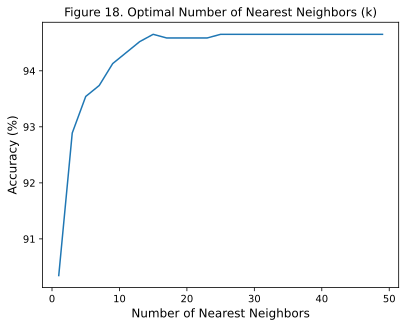

In [66]:
results = []
k_list = []

for k in range(1, 51, 2):
    k_list.append(k)
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train, y_train)
    prediction = classifier.predict(X_test)
    correct = np.where(prediction == y_test, 1, 0).sum()
    results.append(correct*100/len(y_test))
    
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(k_list, results)
ax.set_xlabel('Number of Nearest Neighbors', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
plt.title("Figure 18. Optimal Number of Nearest Neighbors (k)")

plt.show()

# This plot shows that the accuracy maxes out at about k=13